# Gold Price Prediction using Machine Learning

## Import Python Modules and Libraries
Firstly, import all the necessary libraries which are required to implement this strategy.

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Allow multi line cell printing
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression

# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# yahoo finance is used to fetch data
import yfinance as yf

# Date Modules and logic
import datetime as dt
from datetime import date

# ADFuller Stationarity Test
from statsmodels.tsa.stattools import adfuller

## Import and Plot Gold Data
We read the past 12 years of daily Gold ETF price data and store it in Df. We remove the columns which are not relevant and drop NaN values using dropna() function. Then, we plot the Gold ETF close price.

In [2]:
# Download Gold Data from Yahoo Finance
print('Downloading Gold Data from Yahoo Fincance!')
Df = yf.download('GLD', '2008-01-01', '2020-6-22', auto_adjust=True)
print('Complete')

[*********************100%%**********************]  1 of 1 completed
Complete


In [3]:
# Display the Data Frame
Df.head()
Df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2008-01-02,83.559998,85.139999,83.440002,84.860001,12291100
2008-01-03,84.870003,85.940002,84.599998,85.570000,9553900
2008-01-04,85.339996,85.550003,84.430000,85.129997,8402200
2008-01-07,85.239998,85.260002,84.570000,84.769997,6944300
2008-01-08,86.279999,87.129997,86.160004,86.779999,9567900


,Open,High,Low,Close,Volume
Date,,,,,
2020-06-15,160.520004,162.559998,160.160004,162.330002,8532500
2020-06-16,161.850006,162.690002,161.360001,162.250000,7964000
2020-06-17,162.000000,162.619995,161.770004,162.559998,4758200
2020-06-18,162.199997,162.320007,161.440002,162.240005,5397600
2020-06-19,162.869995,164.089996,162.779999,164.029999,12187400


<AxesSubplot:xlabel='Date'>

Text(0, 0.5, 'Gold ETF Prices')

Text(0.5, 1.0, 'Gold ETF Price Series')

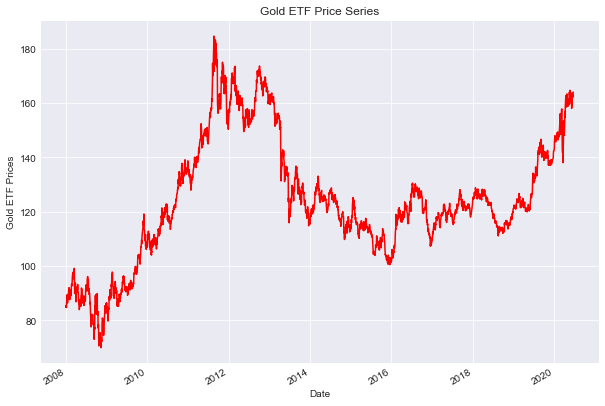

In [4]:
# Drop rows with missing values
Df = Df.dropna()

# Plot the closing price of GLD
Df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()

## Define Explanatory or Independent Variables
An explanatory variable is a variable that is manipulated to determine the value of the Gold ETF price the next day. Simply, they are the features which we want to use to predict the Gold ETF price.

The explanatory variables in this strategy are the moving average for past 3 days and 9 days. We drop the NaN values using dropna() function and store the feature variables in X.

However, you can add more variables to X which you think are useful to predict the prices of the Gold ETF. These variables can be technical indicators, the price of another ETF such as Gold miners ETF (GDX) or Oil ETF (USO), or US economic data.

In [5]:
# Define explanatory variables for our feature list and add them to our pandas dataframe

use_original_feature_list = True

# Creating features
feature_list = []

if use_original_feature_list:
    
    # Original Feature List
    # ---------------------
    
    # 3D Moving Average
    feature_name = 'ma3'
    Df[feature_name] = Df['Close'].rolling(window=3).mean()
    feature_list.append(feature_name)

    # 9D Moving Average
    feature_name = 'ma9'
    Df[feature_name] = Df['Close'].rolling(window=9).mean()
    feature_list.append(feature_name)

else:
    
    # Alternative Feature List
    # ------------------------
    
    # Moving Average based features
    for i in range(10, 30, 5):
        feature_name = 'ma_' + str(i)
        Df[feature_name] = Df['Close'].rolling(window=i).mean()
        feature_list.append(feature_name)
    
    # Volatility based features
    for i in range(5, 20, 5):
        feature_name = 'std_' + str(i)
        Df[feature_name] = Df['Close'].rolling(window=i).std()
        feature_list.append(feature_name)
    
    # Daily pct change based features
    #for i in range(3, 12, 3):
        feature_name = 'pct_' + str(i)
        Df[feature_name] = Df['Close'].pct_change().rolling(i).sum()
        feature_list.append(feature_name)
    
    # Feature based on volume
    feature_name = 'vma_4'
    Df[feature_name] = Df['Volume'].rolling(4).mean()
    feature_list.append(feature_name)

    # Intraday movement
    feature_name = 'co'
    Df[feature_name] = Df['Close'] - Df['Open']
    feature_list.append(feature_name)

    # High-Low Range
    feature_name = 'hl'
    Df[feature_name] = Df['High'] - Df['Low']
    feature_list.append(feature_name)

# Drop rows with NaN
Df = Df.dropna()

# Print the feature list
print(f'Feature List or Explanatary Variables \n{feature_list}')

Feature List or Explanatary Variables 
['ma3', 'ma9']


## Stationarity Test
We typically want to work with prediction features and explanatary variables that are stationary. We can test for stationarity using the Augmented Dickey Fuller test. We can use the ADFullert method from the python statsmodels module to perform this test. The Null Hypothesis $H_0$ is that the series is non-stationary. Therefore a p-value below 0.05 implies that we reject $H_0$ and that the series is stationary at the 95% confidence level.

In [6]:
# function to test if a series is stationary
def isStationary(series):
    pvalue = adfuller(series)
    if (pvalue[1] < 0.05):
        return True
    else:
        return False

# Test if the elements of our feature list are stationary       
print('Testing Feature Explanatory Variables for Stationarity')
for i in range(len(feature_list)):
    result = isStationary(Df[feature_list[i]])
    print(f'{feature_list[i]} {"Stationary" if result == True else "Non-Stationary"}')

Testing Feature Explanatory Variables for Stationarity
ma3 Non-Stationary
ma9 Non-Stationary


## Define the Target or Dependent Variable
Similarly, the dependent variable depends on the values of the explanatory variables. Simply put, it is the Gold ETF price which we are trying to predict. We store the Gold ETF price in y.

In [7]:
# Define dependent variable
Df['next_day_price'] = Df['Close'].shift(-1)

# Drop rows with NaN
Df = Df.dropna()

# After removing any NaN values we can update the Regression X and y values
X = Df[feature_list]
y = Df['next_day_price']

## Split the data into train and test dataset
In this step, we split the predictors and output data into train and test data. The training data is used to create the linear regression model, by pairing the input with expected output.

The test data is used to estimate how well the model has been trained.

- First 80% of the data is used for training and remaining data for testing
- X_train & y_train are training dataset
- X_test & y_test are test dataset

In [8]:
# Split the data into train and test dataset
t = 0.8 
t = int(t*len(Df))

# Train dataset from start to training point, t
X_train = X[:t]
y_train = y[:t]

# Test dataset from training point, t to the end
X_test = X[t:-1]
y_test = y[t:-1]

## Create a Linear Regression Model
We will now create a linear regression model.

If we try to capture a mathematical relationship between ‘x’ and ‘y’ variables that “best” explains the observed values of ‘y’ in terms of observed values of ‘x’ by fitting a line through a scatter plots then such an equation between x and y is called linear regression analysis.

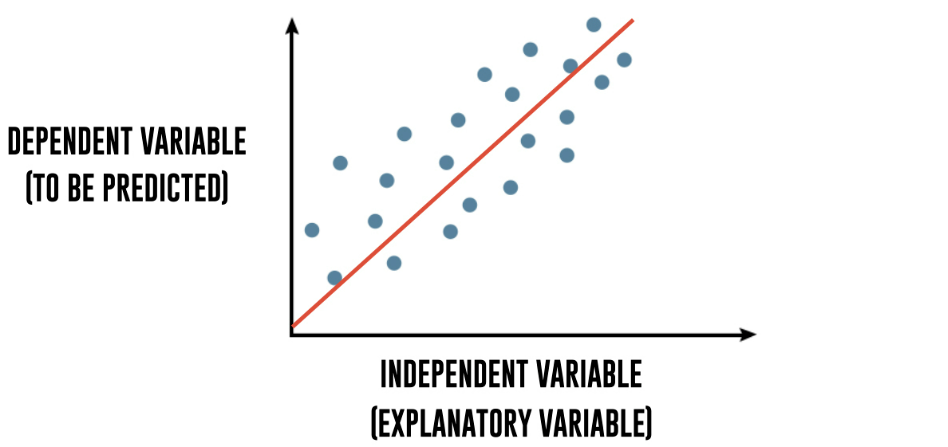

To break it down further, regression explains the variation in a dependent variable in terms of independent variables. The dependent variable - ‘y’ is the variable that you want to predict. The independent variables - ‘x’ are the explanatory variables that you use to predict the dependent variable. The following regression equation describes that relation:

\begin{align}
y = m_1 X_1 + m_2 X_2 + ~C
\end{align}

Then we use the fit method to fit the independent and dependent variables (x’s and y’s) to generate coefficient and constant for regression.

In [9]:
# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)

# Print Regression Coefficients
print(f'Linear Regression Model Coefficients')
print(f'\nFeature, Linear Coefficient')
for i in range(len(feature_list)):
    print(f'{feature_list[i]}, {linear.coef_[i]}')

print(f'\nConstant Term, {linear.intercept_}')

Linear Regression Model Coefficients

Feature, Linear Coefficient
ma3, 1.2034368685688965
ma9, -0.2068100277940955

Constant Term, 0.4301867876394425


## Predict the Gold ETF prices
Now, it’s time to check if the model works in the test dataset. We predict the Gold ETF prices using the linear model created using the train dataset. The predict method finds the Gold ETF price (y) for the given explanatory variable X.

<AxesSubplot:xlabel='Date'>

<AxesSubplot:xlabel='Date'>

Text(0, 0.5, 'Gold ETF Price')

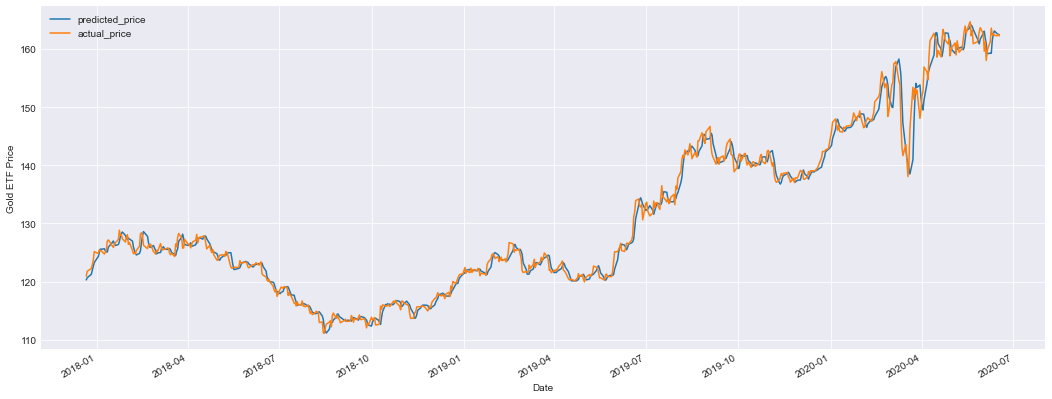

In [10]:
# Predicting the Gold ETF prices
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['price'])

# Plot the Results
predicted_price.plot(figsize=(18, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold ETF Price")
plt.show()

The graph shows the predicted and actual price of the Gold ETF.

## R-Squared Goodness of Fit
Now, let’s compute the goodness of the fit using the score() function.

In [11]:
# R square
r2_score = linear.score(X[t:], y[t:])*100
print(f" R2 Score: {r2_score:.2f}")

 R2 Score: 98.85


As it can be seen, the R-squared of the model is 99.21%. R-squared is always between 0 and 100%. A score close to 100% indicates that the model explains the Gold ETF prices well.

## Plotting cumulative returns
Let’s calculate the cumulative returns of this strategy to analyse its performance.

The steps to calculate the cumulative returns are as follows:
1. Generate daily percentage change of gold price
2. Create a buy trading signal represented by “1” when the next day’s predicted price is more than the current day predicted price. No position is taken otherwise
3. Calculate the strategy returns by multiplying the daily percentage change with the trading signal.
4. Finally, we will plot the cumulative returns graph

In [12]:
gold = pd.DataFrame()

gold['price'] = Df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['actual_returns'] = gold['price'].pct_change().shift(-1)

# long signal
gold['predicted_returns'] = np.log(gold.predicted_price_next_day/gold.predicted_price_next_day.shift(1))
gold['signal'] = np.where(gold['predicted_returns'] > 0, 1, 0)

# short signal (ensure to keep the long signal and not overwrite it)
# gold['signal'] = np.where(gold['predicted_returns']  < 0, -1, gold['signal'])

# show data signal
gold.head(5)
gold.tail(5)

# Uncomment to print results to csv
# gold.to_csv("gold_strategy.csv")

,price,predicted_price_next_day,actual_price_next_day,actual_returns,predicted_returns,signal
Date,,,,,,
2017-12-21,120.309998,120.284457,120.940002,0.005237,NaN,0
2017-12-22,120.940002,120.666413,121.769997,0.006863,0.003170,1
2017-12-26,121.769997,121.237096,122.230003,0.003778,0.004718,1
2017-12-27,122.230003,121.936982,122.849998,0.005072,0.005756,1
2017-12-28,122.849998,122.613092,123.650002,0.006512,0.005529,1


,price,predicted_price_next_day,actual_price_next_day,actual_returns,predicted_returns,signal
Date,,,,,,
2020-06-12,162.619995,163.078395,162.330002,-0.001783,0.003498,1
2020-06-15,162.330002,162.587176,162.250000,-0.000493,-0.003017,0
2020-06-16,162.250000,162.470122,162.559998,0.001911,-0.000720,0
2020-06-17,162.559998,162.416642,162.240005,-0.001968,-0.000329,0
2020-06-18,162.240005,NaN,NaN,NaN,NaN,0


Cumulative Return 17.47 %


<AxesSubplot:xlabel='Date'>

Text(0, 0.5, 'Cumulative Returns')

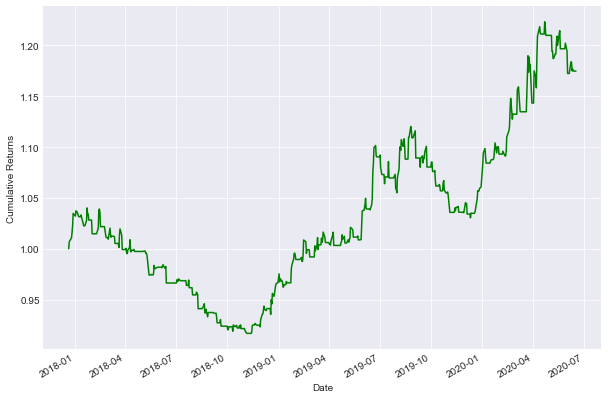

In [13]:
# Compute the Strategy Returns
gold['strategy_returns'] = gold.signal * gold['actual_returns']

# Plot Cumulative Return Series
# This is the equity curve seriers, quoted as a percentage like a bond e.g. 101 means a gain of 1.0%
cumulative_return_series = (1 + gold['strategy_returns']).cumprod()

# Cumulative Return Series is Reported as (1+r)
# We take penultimate value i.e. [-2] as last value is NaN then subtract one to view as a percentage
cumulative_return = (cumulative_return_series[-2] - 1)
print(f'Cumulative Return {cumulative_return*100:.2f} %')

cumulative_return_series.plot(figsize=(10,7),color='g')
plt.ylabel('Cumulative Returns')
plt.show()

## Sharpe Ratio
We will also calculate the Sharpe ratio.

In [14]:
# Strategy mean and standard deviation
mean = gold['strategy_returns'].mean()
std = gold['strategy_returns'].std()

# We scale the sharpe ratio by the anualization factor
# This is computed as the square root of time
annualization_factor = (252**0.5)

# Calculate sharpe ratio
sharpe = (mean / std) * annualization_factor

print(f"Sharpe Ratio {sharpe:.2f}")

Sharpe Ratio 0.73


## Measure Strategy Performance
Using the QuantStats python module we can autogenerate strategy performance as shown below

                    Strategy
------------------  ----------
Start Period        2017-12-21
End Period          2020-06-17
Risk-Free Rate      0.0%
Time in Market      55.0%

Cumulative Return   17.47%
CAGR﹪              4.56%

Sharpe              0.73
Prob. Sharpe Ratio  87.79%
Sortino             1.12
Sortino/√2          0.79
Omega               1.19

Max Drawdown        -11.86%
Longest DD Days     496

Gain/Pain Ratio     0.19
Gain/Pain (1M)      0.71

Payoff Ratio        0.98
Profit Factor       1.19
Common Sense Ratio  1.32
CPC Index           0.64
Tail Ratio          1.11
Outlier Win Ratio   7.48
Outlier Loss Ratio  2.77

MTD                 -2.29%
3M                  3.52%
6M                  13.52%
YTD                 9.91%
1Y                  13.15%
3Y (ann.)           4.56%
5Y (ann.)           4.56%
10Y (ann.)          4.56%
All-time (ann.)     4.56%

Avg. Drawdown       -3.22%
Avg. Drawdown Days  66
Recovery Factor     1.45
Ulcer Index         0.06
Serenity Index      0.18


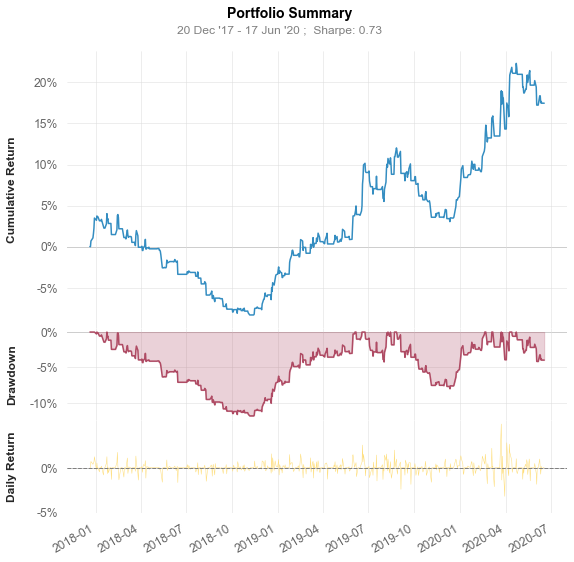

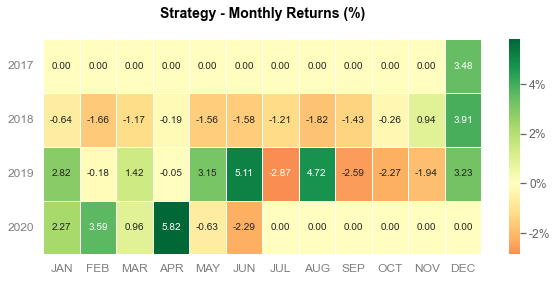

In [15]:
## Strategy Performance
import quantstats as qs
qs.reports.basic(gold['strategy_returns'])

## How to use this model to predict daily moves?
You can use the following code to predict the gold prices and give a trading signal whether we should buy GLD or take no position.

In [16]:
start_date = '2008-06-01'
end_date = '2021-05-15'

# Uncomment for today's date
# end_date = dt.datetime.now()

# Get Gold ETF data and Simple Moving Averages
print('Data Refresh')
data = yf.download('GLD', start_date, end_date, auto_adjust=True)
print('Completed')

# Update Feature Data
data['ma3'] = data['Close'].rolling(window=3).mean()
data['ma9'] = data['Close'].rolling(window=9).mean()
data = data.dropna()

# Forecast the price
data['predicted_gold_price'] = linear.predict(data[feature_list])
data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price, "Buy", "No Position")

# Print the forecast
data.tail(1)[['signal','predicted_gold_price']].T

Data Refresh
[*********************100%%**********************]  1 of 1 completed
Completed


Date,2021-05-14
signal,Buy
predicted_gold_price,171.469703
